# Challenge
Beat the DeepFood paper for Food-101
* 77.4% Accuracy in 250,000 iterations

In [2]:
import tensorflow as tf
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_histories
import tensorflow_datasets as tfds
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 32

# Construct a tf.data.Dataset
(train_data, val_data), ds_info = tfds.load("food101",
                                            split=["train", "validation"],
                                            as_supervised=True,
                                            with_info=True,
                                            data_dir='food101')
class_names = ds_info.features['label'].names

In [12]:
train_one_sample = train_data.take(1)
for image, label in train_one_sample:
    image = image
    label = label

In [13]:
def image_information(title, image):
      print(f"""
        == {title} ==
        Image shape: {image.shape}
        Image datatype: {image.dtype}
        Image (min, max): ({tf.reduce_min(image)},{tf.reduce_max(image)})
        """)


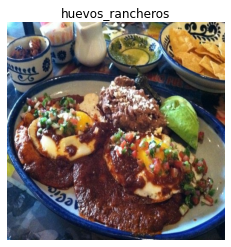

In [14]:
import matplotlib.pylab as plt

plt.imshow(image)
plt.axis(False)
plt.title(class_names[label]);

## Create preprocessing functions

What we know so far:
* The images are in `uint8` datatype
* The images are not resized
* The images are not normalized

What we want:
* Data in `float32`
* Resized images to (224, 224) so we can use batches
* Normalized image tensors (Automatically done by EfficientNet)

In [3]:
def preprocess_image(image, label):
    image = tf.cast(image, tf.float32) # Convert the data to float32 
    return tf.image.resize(image, (224, 224)), label # Resize the image to (224, 224)

## Create batches

In [4]:
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(buffer_size=10000).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_data = val_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
train_data, val_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [46]:
sample = train_data.take(1)
for image, label in sample:
    print(image)

tf.Tensor(
[[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]

 [[228 254 253]
  [226 255 253]
  [223 255 252]
  ...
  [164 159 155]
  [145 141 138]
  [128 127 125]]

 ...

 [[ 66 112 164]
  [ 67 113 163]
  [ 55  99 148]
  ...
  [  5  14  23]
  [  9  18  27]
  [  8  17  26]]

 [[ 76 123 177]
  [ 75 122 176]
  [ 70 116 168]
  ...
  [  5  14  23]
  [  9  18  25]
  [  7  16  23]]

 [[ 80 129 185]
  [ 71 121 174]
  [ 74 121 175]
  ...
  [  7  16  25]
  [ 11  20  27]
  [ 10  19  26]]], shape=(512, 512, 3), dtype=uint8)


## Callbacks

In [5]:
from helper_functions import create_tensorboard_callback
checkpoint_path = "model_checkpoints/cp.ckpt"
checkpoint_callback = ModelCheckpoint(checkpoint_path, 
                                      monitor="val_accuracy",
                                      save_weights_only=True,
                                      save_best_only=True,
                                      mode="max",
                                      verbose=0)
earlystop_callback = EarlyStopping(monitor="val_loss",patience=3,verbose=0,mode="min")

## Mixed precision training

In [6]:
from keras import mixed_precision

mixed_precision.set_global_policy("mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3080, compute capability 8.6


In [6]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [7]:
from keras import layers, Model
from keras import applications
from keras.optimizers import Adam
from keras.losses import SparseCategoricalCrossentropy

base_model = applications.EfficientNetV2B0(include_top=False)
base_model.trainable = False

inputs = layers.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32)(x)
model = Model(inputs, outputs)

model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(),
              metrics=["accuracy"])

In [38]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_8 True float32 <Policy "float32">
efficientnetv2-b0 True float32 <Policy "mixed_float16">
global_average_pooling2d_3 True float32 <Policy "mixed_float16">
dense_3 True float32 <Policy "mixed_float16">
activation_3 True float32 <Policy "float32">


In [11]:
history_1 = model.fit(train_data,
                      epochs=9,
                      steps_per_epoch=len(train_data),
                      validation_data=val_data,
                      validation_steps=int(0.15 * len(val_data)),
                      callbacks=[checkpoint_callback, create_tensorboard_callback('food_vision_challenge','feature_extraction')])

Saving TensorBoard log files to: food_vision_challenge/feature_extraction/20220621-183017
Epoch 1/9
2368/2368 [==============================] - 83s 29ms/step - loss: 1.7469 - accuracy: 0.5765 - val_loss: 1.1509 - val_accuracy: 0.6997
Epoch 2/9
2368/2368 [==============================] - 83s 33ms/step - loss: 1.2136 - accuracy: 0.6851 - val_loss: 1.0315 - val_accuracy: 0.7243
Epoch 3/9
2368/2368 [==============================] - 88s 35ms/step - loss: 1.0652 - accuracy: 0.7217 - val_loss: 1.0042 - val_accuracy: 0.7283
Epoch 4/9
2368/2368 [==============================] - 90s 36ms/step - loss: 0.9704 - accuracy: 0.7432 - val_loss: 0.9776 - val_accuracy: 0.7333
Epoch 5/9
2368/2368 [==============================] - 92s 37ms/step - loss: 0.8994 - accuracy: 0.7627 - val_loss: 0.9749 - val_accuracy: 0.7370
Epoch 6/9
2368/2368 [==============================] - 94s 38ms/step - loss: 0.8446 - accuracy: 0.7766 - val_loss: 0.9582 - val_accuracy: 0.7458
Epoch 7/9
2368/2368 [===================

In [14]:
model.load_weights(checkpoint_path)
results_feature_extract = model.evaluate(val_data)
results_feature_extract

790/790 [==============================] - 21s 26ms/step - loss: 0.9582 - accuracy: 0.7397


[0.9581965208053589, 0.7396831512451172]

Starting point is 73.97%

## Fine-Tuning

In [8]:
model.load_weights(checkpoint_path)

In [9]:
base_model.trainable = True
    
model.compile(loss=SparseCategoricalCrossentropy(),
              optimizer=Adam(learning_rate=0.0001),
              metrics=["accuracy"])

In [10]:
print("Number of trainable variables:", len(model.trainable_variables))
for layer in base_model.layers[-10:]:
    print(layer.name, layer.trainable)


Number of trainable variables: 243
block6h_se_reduce True
block6h_se_expand True
block6h_se_excite True
block6h_project_conv True
block6h_project_bn True
block6h_drop True
block6h_add True
top_conv True
top_bn True
top_activation True


In [9]:
checkpoint_path_fine_tuning = "model_checkpoints_fine_tuning/cp.ckpt"
checkpoint_callback_fine_tuning = ModelCheckpoint(checkpoint_path_fine_tuning, 
                                      monitor="val_loss",
                                      save_weights_only=True,
                                      save_best_only=True,
                                      mode="min",
                                      verbose=0)

In [11]:
history_1_fine_tuning = model.fit(train_data,
                        epochs=100,
                        steps_per_epoch=len(train_data),
                        validation_data=val_data,
                        validation_steps=int(0.15 * len(val_data)),
                        callbacks=[checkpoint_callback_fine_tuning,
                                   earlystop_callback, 
                                   create_tensorboard_callback('food_vision_challenge','fine_tuning')])

Saving TensorBoard log files to: food_vision_challenge/fine_tuning/20220621-193821
Epoch 1/100
2368/2368 [==============================] - 186s 72ms/step - loss: 0.7569 - accuracy: 0.7912 - val_loss: 0.7973 - val_accuracy: 0.7733
Epoch 2/100
2368/2368 [==============================] - 182s 75ms/step - loss: 0.4289 - accuracy: 0.8793 - val_loss: 0.8318 - val_accuracy: 0.7860
Epoch 3/100
2368/2368 [==============================] - 183s 75ms/step - loss: 0.2154 - accuracy: 0.9372 - val_loss: 0.9010 - val_accuracy: 0.7842
Epoch 4/100
2368/2368 [==============================] - 179s 74ms/step - loss: 0.1169 - accuracy: 0.9651 - val_loss: 1.0024 - val_accuracy: 0.7807


In [14]:
model.load_weights(checkpoint_path_fine_tuning)

In [15]:
results_fine_tuning_1 = model.evaluate(val_data)
results_fine_tuning_1

790/790 [==============================] - 21s 27ms/step - loss: 0.7848 - accuracy: 0.7805


[0.7848015427589417, 0.7804752588272095]

# Challenge complete
We got 78.05%, beating the DeepFood paper by 0.65%

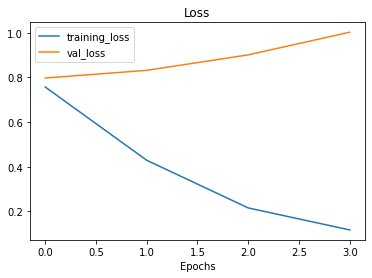

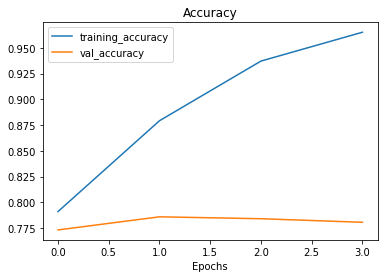

In [16]:
plot_loss_curves(history_1_fine_tuning)

# Visualize results

In [10]:
model.load_weights(checkpoint_path_fine_tuning)

In [11]:
preds = model.predict(val_data)

790/790 [==============================] - 23s 22ms/step


In [18]:
y_labels = [label.numpy() for image, label in val_data.unbatch()]

In [24]:
from sklearn.metrics import classification_report
cl_report = classification_report(y_labels, preds, output_dict=True)
cl_report

{'0': {'precision': 0.7019867549668874,
  'recall': 0.424,
  'f1-score': 0.5286783042394015,
  'support': 250},
 '1': {'precision': 0.788, 'recall': 0.788, 'f1-score': 0.788, 'support': 250},
 '2': {'precision': 0.8783783783783784,
  'recall': 0.78,
  'f1-score': 0.826271186440678,
  'support': 250},
 '3': {'precision': 0.7627118644067796,
  'recall': 0.9,
  'f1-score': 0.8256880733944953,
  'support': 250},
 '4': {'precision': 0.7665198237885462,
  'recall': 0.696,
  'f1-score': 0.7295597484276729,
  'support': 250},
 '5': {'precision': 0.7327935222672065,
  'recall': 0.724,
  'f1-score': 0.7283702213279677,
  'support': 250},
 '6': {'precision': 0.8755020080321285,
  'recall': 0.872,
  'f1-score': 0.87374749498998,
  'support': 250},
 '7': {'precision': 0.9087301587301587,
  'recall': 0.916,
  'f1-score': 0.9123505976095618,
  'support': 250},
 '8': {'precision': 0.476056338028169,
  'recall': 0.676,
  'f1-score': 0.5586776859504132,
  'support': 250},
 '9': {'precision': 0.763392857

In [25]:
class_f1_scores = {class_names[i]:cl_report[f'{i}']['f1-score'] for i in range(len(class_names))}

In [27]:
import pandas as pd
f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)


In [40]:
f1_scores[:10]

,class_name,f1-score
33,edamame,0.987854
63,macarons,0.963415
75,pho,0.930328
88,seaweed_salad,0.919918
69,oysters,0.919765
54,hot_and_sour_soup,0.915187
32,dumplings,0.912500
7,bibimbap,0.912351
64,miso_soup,0.903101
86,sashimi,0.899160


In [29]:
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{:.3f}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(15, -6),
                    textcoords="offset points",
                    ha='center', va='bottom')

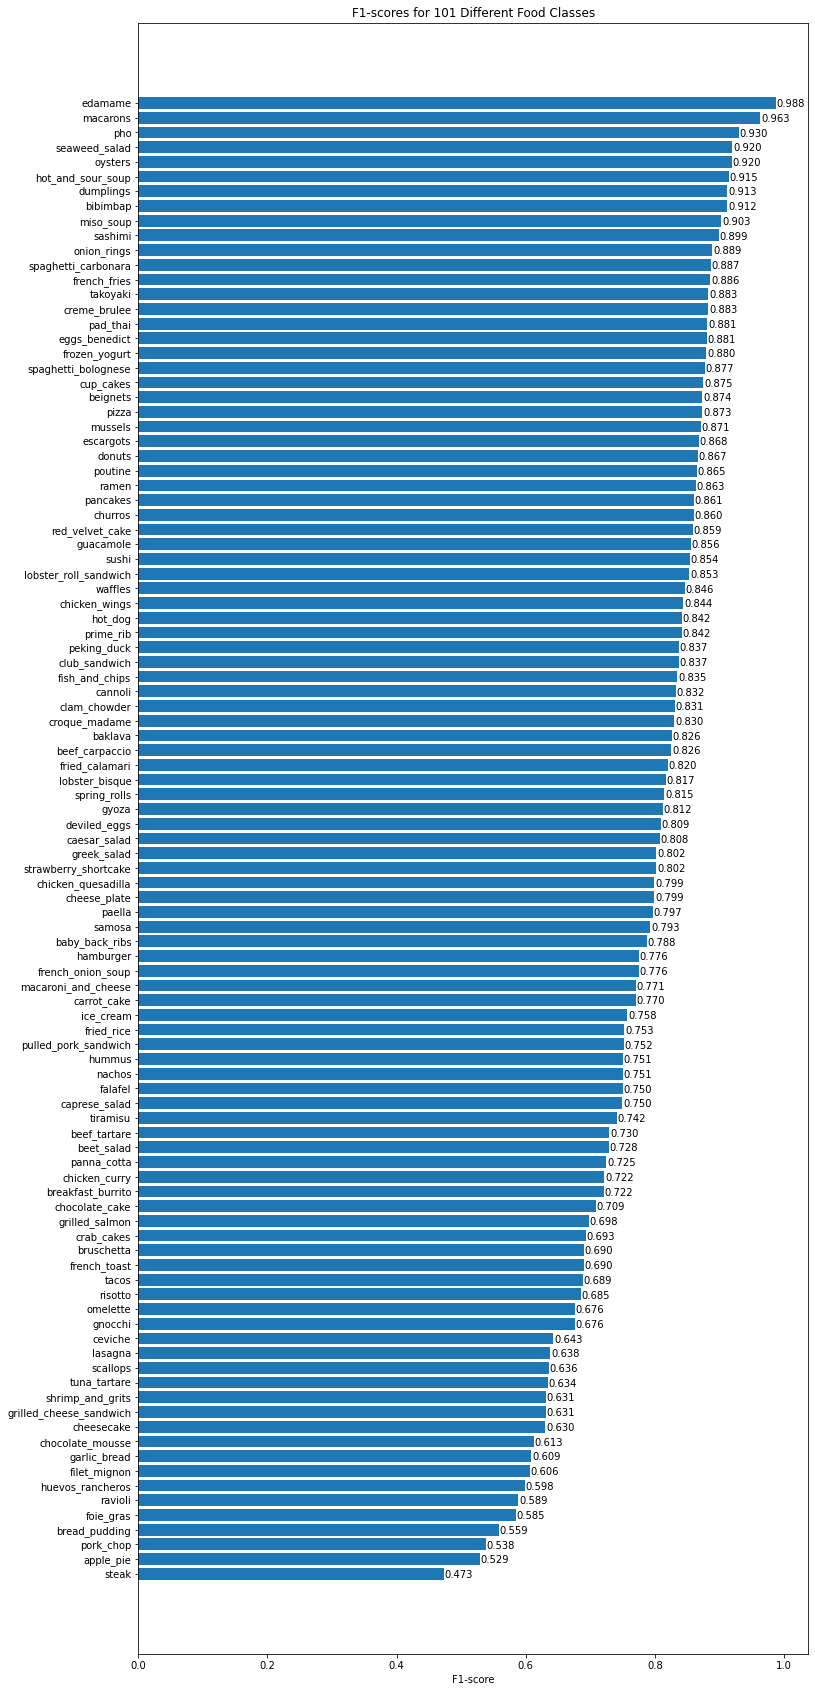

In [30]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 30))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)

ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores['class_name']);
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes");
ax.invert_yaxis()
autolabel(scores.patches)

In [31]:
images = [image for image, label in val_data.unbatch()]

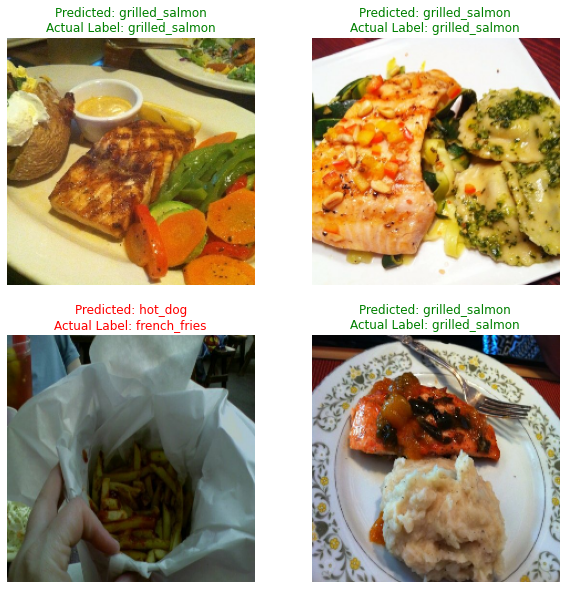

In [39]:
import random
plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    check_image = random.randint(0,len(images))
    plt.imshow(tf.cast(images[check_image],tf.int32))
    plt.title(f"Predicted: {class_names[preds[check_image]]}\nActual Label: {class_names[y_labels[check_image]]}",color='g' if preds[check_image] == y_labels[check_image] else 'r')
    plt.axis(False);